In [13]:
# 核岭回归

In [14]:
## 简单例子

from sklearn.kernel_ridge import KernelRidge
import numpy as np
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
clf = KernelRidge(alpha=1.0)
clf.fit(X, y)

KernelRidge(alpha=1.0)

## KRR和SVR的比较

In [15]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause
import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

rng = np.random.RandomState(0)

In [16]:
# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.cos(X).ravel()


In [17]:
# Add noise to targets
# y中有1万个元素，我们取其中的2000个 ， 1万/5 生成噪声数据
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

In [18]:
# Fit regression model

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

In [19]:
t0 = time.time()
train_size = 100
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("选定SVR复杂度和带宽并拟合模型 in %.3f s"
      % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR复杂性和带宽的选择和模型的拟合 in %.3f s"
      % kr_fit)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], kr_predict))

选定SVR复杂度和带宽并拟合模型 in 0.636 s
KRR复杂性和带宽的选择和模型的拟合 in 0.183 s
Support vector ratio: 0.320
SVR prediction for 100000 inputs in 0.076 s
KRR prediction for 100000 inputs in 0.238 s


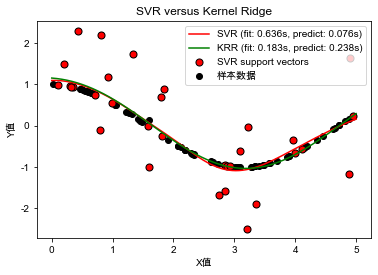

In [20]:
# Look at the results
sv_ind = svr.best_estimator_.support_
plt.scatter(X[sv_ind], y[sv_ind], c='r', s=50, label='SVR support vectors',
            zorder=2, edgecolors=(0, 0, 0))
plt.scatter(X[:100], y[:100], c='k', label='样本数据', zorder=1,
            edgecolors=(0, 0, 0))
plt.plot(X_plot, y_svr, c='r',
         label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))
plt.plot(X_plot, y_kr, c='g',
         label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))
plt.xlabel('X值')
plt.ylabel('Y值')
plt.title('SVR versus Kernel Ridge')
plt.legend()
plt.show()

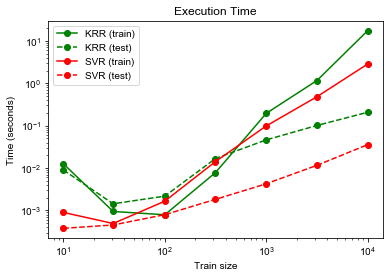

In [23]:
# Visualize training and prediction time
plt.figure()

# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.cos(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))
sizes = np.logspace(1, 4, 7).astype(int)
for name, estimator in {"KRR": KernelRidge(kernel='rbf', alpha=0.1,
                                           gamma=10),
                        "SVR": SVR(kernel='rbf', C=1e1, gamma=10)}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color="r" if name == "SVR" else "g",
             label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color="r" if name == "SVR" else "g",
             label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")
plt.show()

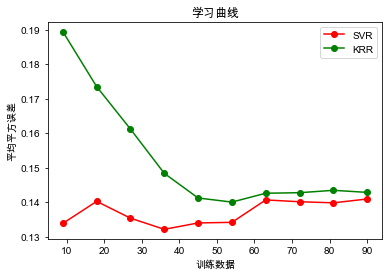

In [24]:
# Visualize learning curves
plt.figure()

svr = SVR(kernel='rbf', C=1e1, gamma=0.1)
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
train_sizes_abs, train_scores_kr, test_scores_kr = \
    learning_curve(kr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")
plt.plot(train_sizes, -test_scores_kr.mean(1), 'o-', color="g",
         label="KRR")
plt.xlabel("训练数据")
plt.ylabel("平均平方误差")
plt.title('学习曲线')
plt.legend(loc="best")

plt.show()



